<a href="https://colab.research.google.com/github/HydroinformaticsLab/ColabWorkshop/blob/master/Exercise_LSTM_TF_Session3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Session 3
This session will bring the ideas for a timeseries forecasting process


This program will use Long Short-Term Memory (LSTM) Artificial recurrent neural network, using past 60 days stock price to predict one time step ahead.

https://medium.com/datathings/the-magic-of-lstm-neural-networks-6775e8b540cd


In [0]:
#libraries
import math
#Web tool to bring data from finance and other websources
import pandas_datareader as web
import pandas as pd
import numpy as np



# **Reading data via API**

In [0]:
df=web.DataReader("AAPL",data_source="yahoo",start="2012-01-01",end="2020-01-01")

Now we explore the contents of what we read

In [10]:
print(df.head())

df.describe()



                 High        Low       Open      Close      Volume  Adj Close
Date                                                                         
2012-01-03  58.928570  58.428570  58.485714  58.747143  75555200.0  50.857235
2012-01-04  59.240002  58.468571  58.571430  59.062859  65005500.0  51.130558
2012-01-05  59.792858  58.952858  59.278572  59.718571  67817400.0  51.698215
2012-01-06  60.392857  59.888573  59.967144  60.342857  79573200.0  52.238651
2012-01-09  61.107143  60.192856  60.785713  60.247143  98506100.0  52.155792


,High,Low,Open,Close,Volume,Adj Close
count,2012.000000,2012.000000,2012.000000,2012.000000,2.012000e+03,2012.000000
mean,127.910026,125.661739,126.788593,126.824191,5.947966e+07,119.806725
std,51.047723,50.245579,50.602207,50.702520,4.683315e+07,52.660444
min,57.085712,55.014286,55.424286,55.790001,1.136200e+07,49.010136
25%,86.726788,85.066071,85.927143,86.231787,2.755815e+07,75.204996
50%,114.200001,111.920002,113.055000,113.050003,4.343225e+07,105.417351
75%,167.469997,163.517498,165.397503,165.252499,7.470960e+07,160.467850
max,293.970001,289.519989,291.119995,293.649994,3.765300e+08,292.163818


If we want to explore other ploting options we can use Bokeh library

In [0]:
from bokeh.plotting import figure,show
from bokeh.io import output_notebook
from bokeh.models import ColumnDataSource
plt.style.use("fivethirtyeight")

BD=ColumnDataSource(df)

(2012, 6)

# **Preview stock data loaded**

In [11]:
#visualize the closing price
plt.figure(figsize=(62,7))

output_notebook()
p=figure(title="Closing stock markets ")
p.circle(x='Date',y='Close',source=BD)
show(p)

<Figure size 4464x504 with 0 Axes>

Text(0.5, 0, 'Date')

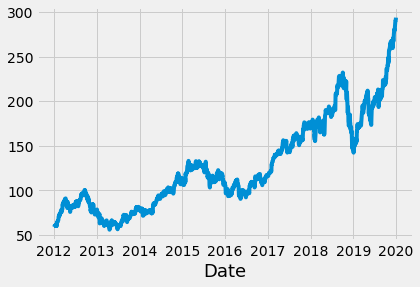

In [12]:
import matplotlib.pyplot as plt

plt.plot(df["Close"])
plt.xlabel("Date",fontsize=18)

# **Training set**
Creating the trainning sub data (need to extract firs the column that will have the input from all the table)

First we import the libraries for scientific processing

In [0]:
#Tool for scientific data processing
from sklearn.preprocessing import MinMaxScaler
from tf.keras.models import Sequential
from tf.keras.layers import Dense, LSTM


We create a data frame of only one column, which will help to manage the time series analysis.

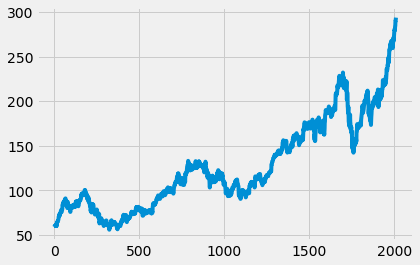

In [14]:

#create a new dataframe 
data=df.filter(["Close"])
#Convert data frame into a numpy
dataset=data.values
plt.plot(dataset)


## Taraining data set lenght

We select in this case, 80% of sample for training.

In [15]:
#get number of rows
training_data_len=math.ceil(len(dataset)*.8)
training_data_len

1610

# **Normalization of input data**


To be able to solve the optimization problem we need to normalize inputs and outputs, for this we can use the MinMaxScaler. The suggested option for this exercise is a range from [0,1]

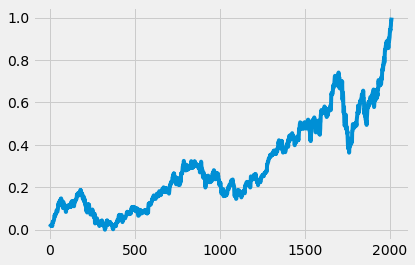

In [16]:
scaler=MinMaxScaler(feature_range=(0,1))
scaled_data=scaler.fit_transform(dataset)
#TD=ColumnDataSource(scaled_data)
#p.circle(x=a,y=)
#show(p)
plt.plot(scaled_data)

After scaling the data we need to organize it such that you can have an input matrix of lagged time series and one output vector (array), which will be the target ($y$)

#training data set
Our assumption is that the best is an autoregressive model, with at least 60 Columns of inputs and the target value of the next time step (Stock price + 1)

In [0]:
train_data=scaled_data[0:training_data_len,:]

x_t=[]
y_t=[]

for i in range (61,len(train_data)):
  x_t.append(train_data[i-60:i,0])
  y_t.append(train_data[i,0])


In [27]:
print("length of input samples each with 60 element "+ str(len(x_t)))

length of input samples each with 60 element 1549


In [0]:
#conver x_t and y_t to numpy arrays for training the LSTM model
x_train, y_train = np.array(x_t),np.array(y_t)


In [29]:
x_train.size

92940

In [31]:
#reshape data we need it to be 3D 
#Number of samples is n
#number of time steps is 60
#number of features is one forecast
x_train=np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))
x_train.shape

(1549, 60, 1)

#Building the sequential model

In [0]:
#buil model
model=Sequential()
# sequential mean MLP 

# using 50 neurosn and we are adding one layer
model.add(LSTM(50,return_sequences=True,input_shape=(x_train.shape[1],1)))
model.add(LSTM(50,return_sequences=False))

# Dense layer are sum * w, so just adding all up to number of neurons
model.add(Dense(25))
#Adding to the one output
model.add(Dense(1))



In [0]:
#optimization
model.compile(optimizer='adam',loss='mean_squared_error')


In [36]:
x_train.shape
model.fit(x_train,y_train, batch_size=1,epochs=1)

Epoch 1/1
1549/1549 [==============================] - 53s 34ms/step - loss: 2.3793e-04


In [0]:
#create the testing data set
# create new from 1549 to the end (200?)


test_data=scaled_data[training_data_len-60:2003,:]
#creating the data set x and y

x_test=[]
y_test=dataset[training_data_len:,:]

for i in range(60,len(test_data)):
  x_test.append(test_data[i-60:i,0])


In [38]:
#Convert data to a numpy array
x_test=np.array(x_test)
x_test.shape

(393, 60)

In [0]:
#Reshape the data
x_test=np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))

In [0]:
#prediction
pre=model.predict(x_test)
pre=scaler.inverse_transform(pre)

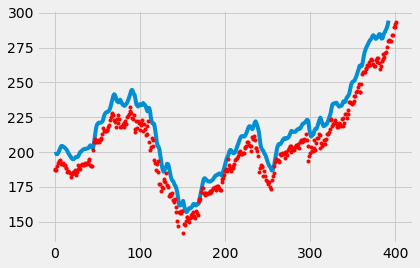

In [41]:
plt.plot(pre)
plt.plot(y_test,'r.')

In [0]:
#error analysis

rmse=np.sqrt(np.mean(pre-y_test[0:393])**2)

In [0]:
print(rmse)

1.7456969050050692
